<a href="https://colab.research.google.com/github/mo-alrz/Machine-learning/blob/main/Day02_Practice_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Keras

After the first wave of autodifferentiation frameworks the need for a more **user friendly, high level "scikit like" computational library focused on neural networks** was obvious. Though different approaches were taken to this ([TFlearn](http://tflearn.org/), [SKFlow](https://github.com/tensorflow/skflow)), the most famous and widespread one is [Keras](https://keras.io/) by [François Chollet](https://www.linkedin.com/in/fchollet/). (The project in fact became so popular, that **TensorFlow decided to incorporate it** into the main codebase, so [**tf.Keras**](https://www.tensorflow.org/api_docs/python/tf/keras) is - since 2017 - part of the main TF deployment, and finally, in 2019 it completely puhed out tf.layers from support, and became the de facto standard layer API in TF.)

__It is advisable to always use the `tf.keras` version!__

The library aims to be an abstract, high level "frontend" for other libraries. Currently the models defined in Keras can be executed in TensorFlow, [CNTK](https://github.com/Microsoft/CNTK) and [Theano](https://theano-pymc.readthedocs.io/en/latest/). (As a "joke", for tf.keras being part of TF, Keras' backend is TF itself. :-)

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTIeDOxUfzg_LhPmGrpXp2r5QDwAFBQ7CpqdxnHzsThBOFKv4p-" width=400px>

It also lays emphasis on the high level, compact syntax with minimal "boilerplate", thus aims rapid prototyping.

It has **two "API" approaches**:
- the _"Sequential"_ API,
- and the _"Functional"_ API.


The suggested way / levels of development:

<img src="http://drive.google.com/uc?export=view&id=1pbSvYLtwO_8Q31S7kXk1KDbflSIanrYl" width=800px>


The keras workflow:

<img src="https://www.learnopencv.com/wp-content/uploads/2017/09/keras-workflow.jpg" width=800px>


## Keras Sequential API

"Sequential" is an object oriented, **strictly sequential** model for building up networks.

The `input_shape` (alternatively, only `input_dim`, which is vector length) to the model must be specified.

```python
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

model = Sequential()

model.add(Dense(units=number_of_hidden_units, input_shape=(data_rows_number,data_columns_number)))
# Please note, that we have to deal with input_dim or input_shape here!

model.add(Dense(units=number_of_second_layer_hidden_units, activation='relu'))
model.add(Dense(units=number_of_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# In case of regression this would be:
# model.add(units=1, activation='linear')
# model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['MeanAbsoluteError'])

model.fit(x_train, y_train, epochs=5, batch_size=32)

```

<img src="http://drive.google.com/uc?export=view&id=1RB7e5QJEbPIwMFJBJymVb7g-om4t-eST" width=75%>

## Keras Functional API

In this approach the Keras model is built up of a series of function calls, each taking the (some) other function's output as input.

The underlying computational graph is being built up when we instantiate a `model=Model()` object, defining it's inputs and outputs (whereby inputs are self explanatory, and _outputs are the last function_ we have called in the "chain"). The compile to a eg. a TF graph happens when we call `model.compile()`.

The main advantage of the Functional API is, that it does not presuppose the "sequential" nature of the "layers", operations, thus parallelly outputting two vectors, concatenating them and moving on with the model is not a problem,... It's increased flexibility can be advantageous.

In fact, Keras' functional API heavily influenced `tf.layers`, or better to say it is completely overtaking it, so basically all the layers we have used thus far are in fact Keras layers.

The code comment says:
```python
class Layer(base_layer.Layer):
  """Base layer class.
  It is considered legacy, and we recommend the use of `tf.keras.layers.Layer`
  instead.
```
[source](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/legacy_tf_layers/base.py)

## Same network defined in Functional API

```python
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model

input_layer = Input(shape=(data_rows_number,data_columns_number))

layer1_out = Dense(number_of_hidden_units, activation='linear')(input_layer)
layer2_out = Dense(number_of_second_layer_hidden_units, activation='relu')(layer1_out)
output = Dense(number_of_classes, activation='softmax')(layer2_out)

# In case of regression this would be:
# output = Dense(1, activation='linear')(layer2_out)


model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# In case of regression this would be:
# model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['MeanAbsoluteError'])

model.fit(x_train, y_train, epochs=5, batch_size=32)

```


## Example for sequential with spiral dataset

In the following we are going to build and fit a Neural Network for the spiral like dataset. It will be a classfication problem solved by keras. We have modified the original exmple (<a href="https://web.archive.org/web/20190420140057/http://datahacker.rs:80/tf-an-implementation-of-a-shallow-neural-network-in-keras-spirals-dataset/">source</a>) a little bit in order to converge later, and have real-life-like loss curves.

#### Data preparation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import keras
import warnings
from mpl_toolkits import mplot3d
from matplotlib import cm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_s_curve
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [ ]:
# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# We need to generate two sets of data
def spirals(points, noise=1.5):
    n = np.sqrt(np.random.rand(points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(points),np.ones(points))))
X, y = spirals(1000)

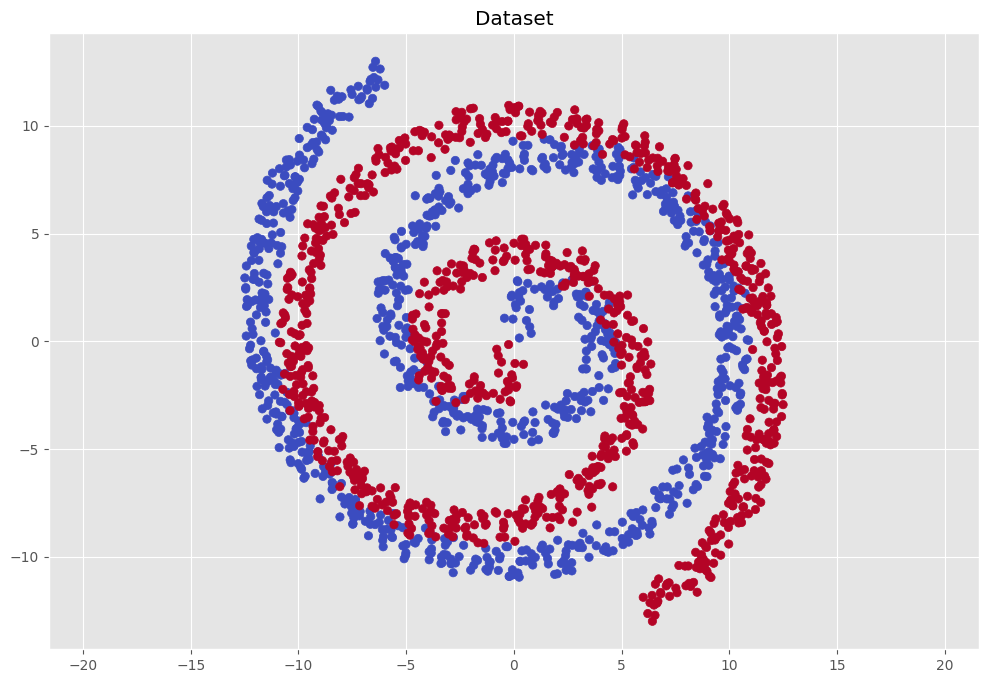

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(X[:,0], X[:,1], c=y ,cmap=cm.coolwarm)
plt.title('Dataset')
plt.axis('equal');

In [ ]:
print('X:\t{}' .format(X.shape))
print('y:\t{}' .format(y.shape))
print(type(X))
print(type(y))

# Spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

# Checking the shape of the input data
print('X_train:\t{}' .format(X_train.shape))
print('y_train:\t{}' .format(y_train.shape))
print('X_valid:\t\t{}'.format(X_valid.shape))
print('y_valid:\t\t{}'.format(y_valid.shape))
print('X_test:\t\t{}'.format(X_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))


X:	(2000, 2)
y:	(2000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
X_train:	(1400, 2)
y_train:	(1400,)
X_valid:		(300, 2)
y_valid:		(300,)
X_test:		(300, 2)
y_test:		(300,)


### Model creation and training with keras

**General considerations:**
- If you create/train multiple models: Always [**clear session**](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) to delete any previous computation graphs.
- Try to set seed for [**reproducibility**](https://keras.io/examples/keras_recipes/reproducibility_recipes/).
- Hint: worthwhile using GPU if available!

**Neural network creation and training:**
- create model with sequential or functional API
- `.compile()` model.
- scikit-like `.fit()` to train model.
  - but specify epochs and batch size
  - ideally use validation data


In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

K.clear_session()
tf.keras.utils.set_random_seed(42)


In [ ]:
# Hyperparameters
training_epochs = 1000 # Total number of training epochs
learning_rate = 0.005 # The learning rate

# create a model
def create_model():
      model = Sequential()
      # Input layer
      model.add(Dense(14, input_dim=2, kernel_initializer='normal', activation='relu'))
      model.add(Dense(8,activation='relu'))
      # Output layer
      model.add(Dense(1, activation='sigmoid'))

      # Compile a model
      model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
      return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                42        
                                                                 
 dense_1 (Dense)             (None, 8)                 120       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 171 (684.00 Byte)
Trainable params: 171 (684.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training:


In [ ]:
# Let's train the model for a given number of epochs.
results = model.fit(
 X_train, y_train,
 epochs = training_epochs,
 batch_size = 512,
 validation_data = (X_valid, y_valid),
 verbose = 0, # We only do this, because to avoid printing out 1000 lines. So we disable keras status prints
)

#### Check training history

In [ ]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Maximum Loss : 0.7001

Minimum Loss : 0.1437

Loss difference : 0.5564


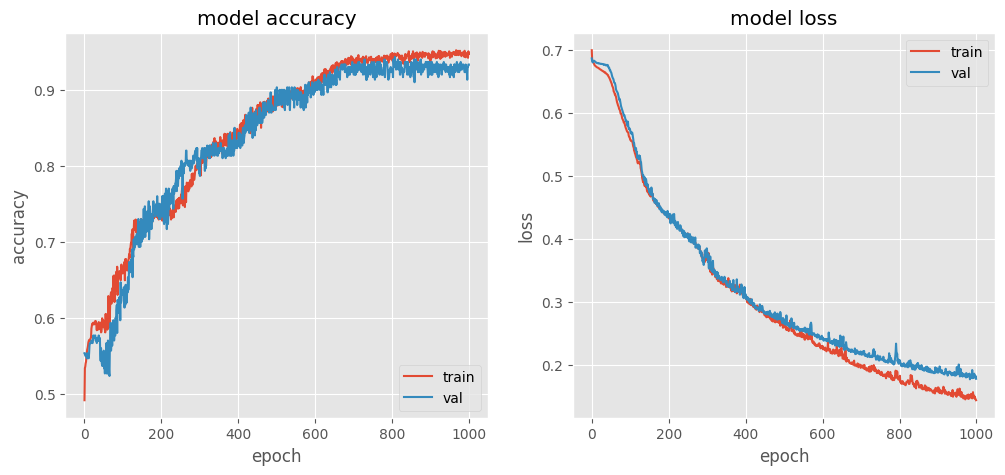

In [ ]:
# summarize history for accuracy
plt.figure(figsize = (12,5))
plt.subplot(121)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

# summarize history for loss
plt.subplot(122)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

max_loss = np.max(results.history['loss'])
min_loss = np.min(results.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("")
print("Minimum Loss : {:.4f}".format(min_loss))
print("")
print("Loss difference : {:.4f}".format((max_loss - min_loss)))


#### Evaluation

In [ ]:
# The model can generate output predictions for the input samples.
prediction_values = model.predict(X_test)
print("Prediction values shape:", prediction_values.shape)
# Turn predicted probabilities into classes:
prediction_values = np.round(prediction_values).astype(int)

# Now we can check the accuracy of our model
print("Evaluating on training set...")
(loss, accuracy) = model.evaluate(X_train, y_train)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

print("Evaluating on testing set...")
(loss, accuracy) = model.evaluate(X_test, y_test)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

10/10 [==============================] - 0s 2ms/step
Prediction values shape: (300, 1)
Evaluating on training set...
44/44 [==============================] - 0s 3ms/step - loss: 0.1431 - accuracy: 0.9486
loss=0.1431, accuracy: 94.8571%
Evaluating on testing set...
10/10 [==============================] - 0s 3ms/step - loss: 0.1676 - accuracy: 0.9433
loss=0.1676, accuracy: 94.3333%


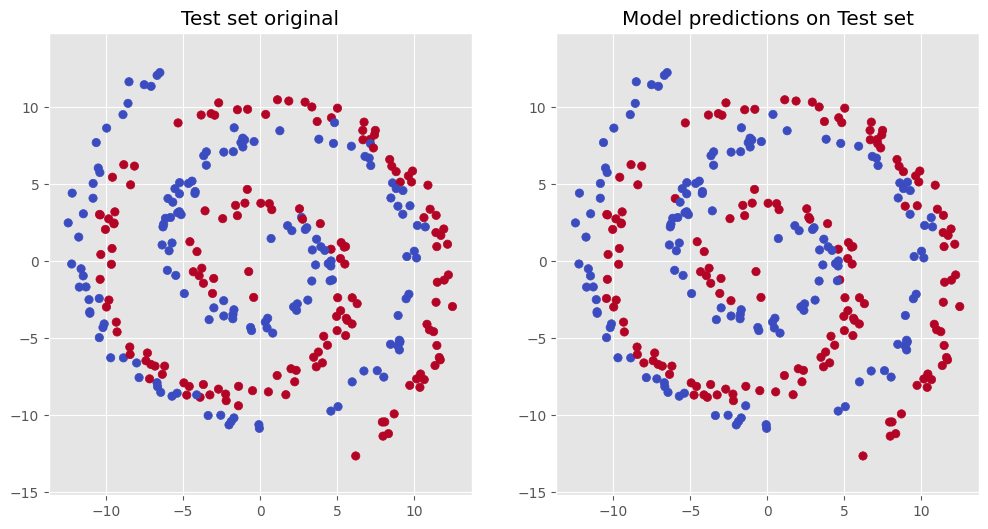

In [ ]:
# Visualization of the model predictions on our training set
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test ,cmap=cm.coolwarm)
plt.title('Test set original')
plt.axis('equal');

# Visualization of the model predictions on our test set
plt.subplot(122)
plt.scatter(X_test[:,0], X_test[:,1], c=prediction_values[:,0], cmap=cm.coolwarm)
plt.title('Model predictions on Test set')
plt.axis('equal');

5000/5000 [==============================] - 9s 2ms/step


Text(0.5, 1.0, 'Decision Boundary and model predictions on Test set ')

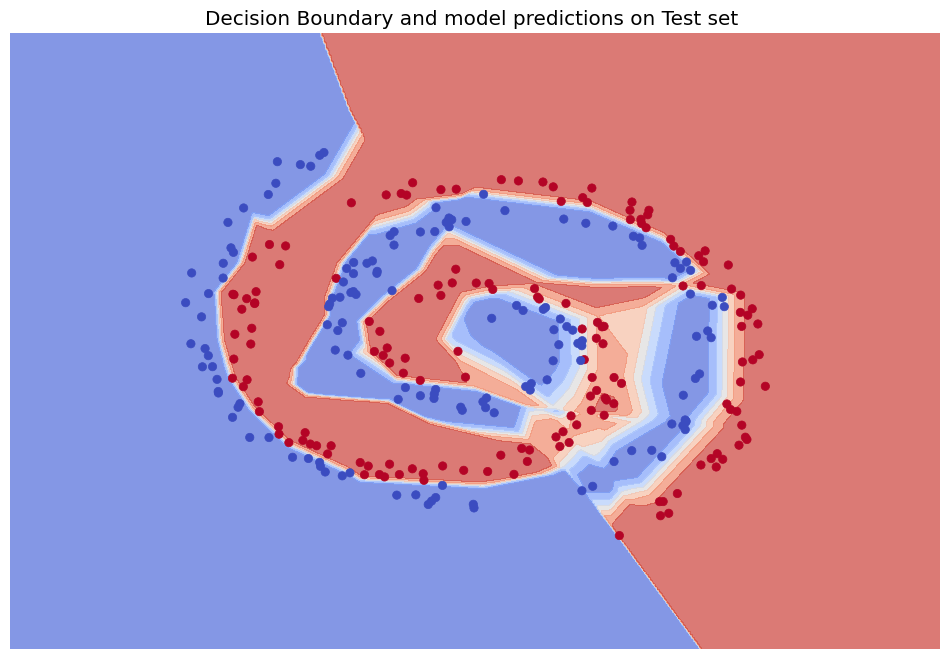

In [ ]:
# We can now see how our model separates the classes.
plt.figure(figsize=(12,8))
xx = np.linspace(-20, 20, 400)
yy = np.linspace(-20, 20, 400)
gx, gy = np.meshgrid(xx, yy)
Z = model.predict(np.c_[gx.ravel(), gy.ravel()])
Z = Z.reshape(gx.shape)
plt.contourf(gx, gy, Z, cmap=plt.cm.coolwarm, alpha=0.7)

axes = plt.gca()
axes.set_xlim([-20, 20])
axes.set_ylim([-20, 20])
plt.grid('off')
plt.axis('off')

plt.scatter(X_test[:,0], X_test[:,1], c=prediction_values[:,0], cmap=cm.coolwarm)
plt.title('Decision Boundary and model predictions on Test set ')

# End note: Keras and Scikit

Naturally enough, Keras' `.fit() - .predict()` syntax is not accidental.

It is not just true, that Keras got inspiration from Scikit-Learn, but that it is actively developed to be compatible for example with the `pipeline` of Scikit, or can be part of a "grid search" for parameters with `sklearn.model_selection.GridSearchCV`

See more [here](https://keras.io/scikit-learn-api/)

## Example code

[Source](https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/)

(This is indeed not a realistic scenario, the parameters over which we do the grid are not well thought out. Purpose is: show how it works.)

In [ ]:
!pip install scikeras

In [ ]:
# Bad practice, but good if you present a notebook :-)
import warnings
warnings.filterwarnings('ignore')


# MLP for Pima Indians Dataset with grid search via sklearn
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy

# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset

!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv

dataset = numpy.loadtxt("pima-indians-diabetes.data.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# create model
model = KerasClassifier(build_fn=create_model, init='glorot_uniform', verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
epochs = [2, 5, 10]
batches = [5, 10]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, verbose=3)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

--2023-10-24 15:24:22--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23278 (23K) [text/plain]
Saving to: ‘pima-indians-diabetes.data.csv.2’

pima-indians-diabet 100%[===================>]  22.73K  --.-KB/s    in 0.003s  

2023-10-24 15:24:22 (7.55 MB/s) - ‘pima-indians-diabetes.data.csv.2’ saved [23278/23278]

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END batch_size=5, epochs=2, optimizer=rmsprop;, score=0.568 total time=   2.8s
[CV 2/2] END batch_size=5, epochs=2, optimizer=rmsprop;, score=0.557 total time=   1.4s
[CV 1/2] END batch_size=5, epochs=2, optimizer=adam;, score=0.583 total time=   2.1s
[CV 2/2] END batch_size=5, epochs=2, op

## Finally: Full circle

And even more importantly, since Keras has Tensorflow as backend, and it is itself (more and more dominant) part of TF, we came full circle, and get back to being able to use TF under Scikit, proving the interconnectedness of the Python AI stack, for example the powerful [Scikit-Optimize](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html) hyperparameter optimization library, which is a drop-in replacement for Scikit's GridSearchCV. Besides this [Dask](https://github.com/dask/dask) as a new player in parallelization of Pythonic workloads (with a Pandas syntax and a strong task scheduler), and because of Dask compatibility the nascent [Rapids](https://developer.nvidia.com/rapids) environment is also converging to be unified, thus promiosing huge boost with parallelisms and GPU workflows (as an alternative to the strong, but really complex parallel solutions of TF itself).

(Sidenote: Though immature and quite dangerous in a sense - like usage without understanding - the machine learning workflow gets more and more automated, so whoever enjoyed Keraspandas, will most probably like [auto_ml](https://auto-ml.readthedocs.io/en/latest/index.html) as well.)